In [1]:
#Keep this line if you want matplotlib to show inline instead of a seperate window

%matplotlib inline


In [2]:
#We define initial parameters

region_file="observed_target_info.reg"

output_file="output NUV.csv" #The output file name including the file extension

fits_directory='./' #The directory to look for .fits files in   

file_key = "nd-int" #A string located in all the files you want to analyze in fits_directory
check_file_key = "nd-wt" #A string to replace file_key when running photometry on the check file

flux_conv = 2.06*(10**(-16)) 
        # A conversion factor from pixel count to flux in units of (erg cm-2 Å-1)/(N/s)
        #NUV: Flux = 2.06*10**(-16) x CPS, FUV: Flux = 1.40*10**(-15) x CPS
        #Reference: http://asd.gsfc.nasa.gov/archive/galex/FAQ/counts_background.html

flux_conv_err = 0 #error in flux_conv
    
pixel_area=(1.5/60)**2 #Arcmin^2 per pixel - given in arcseconds, converted to arcmin, and squared to find area in arcmin^2.

pixel_area_err = 0 #error in pixel_area


In [3]:
#General use
import numpy as np
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo

#For creating a list of .fits files to perform photometry on
import os

#For reading and creating tables
from astropy.table import Table, Column
import astropy.io.ascii as asc

#For performing photometry
from astropy import units as u
from photutils import aperture_photometry, SkyCircularAperture, CircularAperture
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

#For generating a plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

/Users/Daniel/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
#We define functions used to calculate error

def Conv_error(val,err): #uncertanty in the conversion factor from arcmin^2 to Kpc^2 using arguments (redshift, redshift error)
    return(
            abs(((1/cosmo.kpc_comoving_per_arcmin(val+err))**2-(1/cosmo.kpc_comoving_per_arcmin(val-err))**2)/2).value
          )

def Comov_error(val,err): #Uncertanty in the comoving_distance using arguments (redshift, redshift error)
    return(
            abs(((cosmo.comoving_distance(val+err).cgs)-(cosmo.comoving_distance(val-err).cgs))/2).value          
                )

def Flux_error(val_1,err_1): #uncertanty in flux using arguments (counts per second, error in counts per second)
    return(
        ((val_1*flux_conv_err)**2+(flux_conv*err_1)**2)**(1/2)
            )

def Luminosity_error(flux,flux_err,dist,dist_err): #The input 'dist' is Comoving Distance
    return(
        ((4*np.pi*(dist**2)*flux_err)**2+(8*np.pi*dist*flux*dist_err)**2)**(1/2)
    )

def Sbrightness_error(lum,lum_err,conv,conv_err): #Uncertanty in surface brightness
    return(
        ((conv*lum_err/pixel_area)**2+(lum*conv_err/pixel_area)**2+
         (lum*conv*pixel_area_err/(pixel_area**2))**2)**(1/2)
    )


In [5]:
#We define a function to perform photometry on a .fits file. When given the file path of a .fits file it checks to see
#if there is a supernova observed in that file. If it finds one it returns the supernova name, a table of photometry 
#results, and the .fits file's exposure time

def photometry(fits_file):
    #open the file and create an hdulist
    hdulist = fits.open(fits_file)
    sci = hdulist[0].data
    wcs = WCS(fits_file)

    for sn in cord:

        #Define the SN location in pixels
        w = wcs.all_world2pix(cord[sn].ra,cord[sn].dec, 1)
        
        #Make sure the sn is located in the image, and near the data pixels (aka 200 pixels away from the image edge)
        if 0<w[0]<3600 and 0<w[1]<3600:

            #get exposure time and calculate error array
            exp_time = hdulist[0].header['EXPTIME']
            error = ((hdulist[0].data*exp_time)**(1/2))/exp_time
            
            #Find arcmin of 1kpc radius region
            r = 2*u.kpc/cosmo.kpc_comoving_per_arcmin(float(red[sn]))
            
            #Create an aperture
            aperture = SkyCircularAperture(cord[sn], r) 
            

            #Perfom photometry
            phot_table = aperture_photometry(hdulist[0], aperture, error=error)
            

            #We add values to their respective lists, which will be writen to the output file. 
            #Note that if the photometry = 0, we run zero_check which lets the user manually determine if 
            #the aperture is in the data region
            if phot_table[0][0]!=0:
                return([sn,phot_table,hdulist[0].header['EXPTIME']])
            
            elif zero_check(fits_file, cord[sn], r)==True:
                return([sn,phot_table,hdulist[0].header['EXPTIME']])
            
            elif zero_check(fits_file, cord[sn], r)=='none':
                return('none')
            
    #close the hdulist
    hdulist.close()
    return(False)



In [6]:
#The zero_check function is passed a .fits file, along with the cordinates and radius of an aperture. It then performs
#photometry on a wt file and determines if there are data pixels in the aperture.

def zero_check(fits_file, cord, r):

    try: 
        hdulist = fits.open(fits_file.replace(file_key,check_file_key))
        aperture = SkyCircularAperture(cord, r)
        phot_table = aperture_photometry(hdulist[0], aperture)
        return(phot_table[0][0]!=0)
    
    except:
        return('none')



In [7]:
#We create a list of .fits files to perform photometry on

file_list = []

for path, subdirs, files in os.walk(fits_directory):
    for name in files:
        if file_key in name: file_list.append(os.path.join(path, name))


In [8]:
#Create a dictionary of coordinates (in degrees) and redshift by using values from the .reg file

reg = asc.read(region_file, data_start=2, delimiter = "#", header_start=2)
cord, red = {}, {}

for row in reg: 
    cord[row[1].split(",")[0].strip('text={}')] = SkyCoord(row[0].strip('point()').replace(',',' '), unit=(u.hourangle, u.deg))
    red[row[1].split(",")[0].strip('text={}')] = row[1].split(",")[2].strip('}').replace('z=','')


In [9]:
#We define lists and an array for the output files

n=0
log = np.array([['Issue', 'File Path']])
out = np.array([['Sn Name', 'Red shift', 'Redshift error', 'ArcMin^2 per Kpc^2 at Redshift', 'ArcMin^2 / Kpc^2 error', 'Photometry', 'Exposure Time (s)', 'Photometry Error N^(1/2)/s', 'Flux (erg s-1 cm-2 A-1 px-1)', 'Flux error (erg s-1 cm-2 A-1 px-1)', 'Luminosity (erg s-1 A-1 px-1)', 'Luminosity Error (erg s-1 A-1 px-1)', 'Surface Brightness (erg s-1 A-1 Kpc^-2)', 'Surface Brightness error (erg s-1 A-1 Kpc^-2)', 'log10 of Surface Brightness', 'Error in log10', 'File Path']])

#We perform photometry on each .fits file

for fits_file in file_list:
    print(fits_file,'\n')
    p = photometry(fits_file)
    
    if p==False: 
        log = np.vstack((log, np.array([['No Supernova Found', fits_file]])))
        
    elif p=='none':
        log = np.vstack((log, np.array([['No Check File', fits_file]])))
  
    else:
        n+=1
        
        #We calculate the values in the table
        
        redshift = float(red[p[0]])
        redshift_err = ((redshift/1000)**2+(300/(299792.458))**2)**(1/2) #Error in redshift taken as 1 in 1000 with an additional 300 km/s contribution from peculiar velocity
        
        arcmin = (1/cosmo.kpc_comoving_per_arcmin(redshift).value)**2
        arcmin_err = Conv_error(redshift, redshift_err)
        
        photom = p[1][0][0]
        photom_err = p[1][0][1]
        
        flux = flux_conv*photom #convert cps to flux using the conversion factor
        flux_err = Flux_error(photom,photom_err)
        
        cmd = cosmo.comoving_distance(redshift).cgs.value #Comoving Distance at Redshift (cm)
        cmd_err = Comov_error(redshift,redshift_err)
        
        lum = flux*4*np.pi*(cmd**2) #luminosity = flux*4*pi*r^2
        lum_err = Luminosity_error(flux,flux_err,cmd,cmd_err)
        
        sbrightness = (lum/pixel_area)*arcmin
        sbrightness_err = Sbrightness_error(lum,lum_err,arcmin,arcmin_err)
        
        log_sbrightness = np.log10(sbrightness)
        log_sbrightness_err = sbrightness_err/(sbrightness*np.log(10))
        
        row = np.array([[p[0] , redshift, redshift_err, arcmin, arcmin_err, photom, p[2],
                         photom_err, flux, flux_err, lum, lum_err, sbrightness, sbrightness_err,
                        log_sbrightness, log_sbrightness_err, fits_file]])
        
        out = np.vstack((out, row))
        

print('\nPhotometry finished:', n, 'supernova oberved.')


Photometry finished: 130 supernova oberved.


In [10]:
#We keep only the results for each supernova with the smallest error values

out_unique = out[0,:] #We create a new array with the first row of out. This row contains the collumn names 'Sn Name', 'Red shift', 'Redshift error', etc. 

for entry in out: 
    if entry[0] not in out_unique:
        out_unique = np.vstack((out_unique,entry))
    else: 
        for row in out_unique:
            if entry[0]==row[0] and entry[13]<row[13]: row=entry


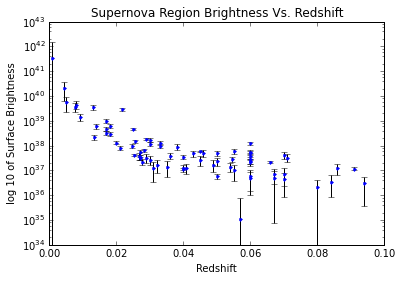

In [11]:
#We create a plot of the results and write them to a pdf file


r, s, s_err = [], [], []
    
for row in out_unique: 
    r.append(row[1])
    s.append(row[12])
    s_err.append(row[13])

r = [float(i) for i in r[1:]] #A list of the redshift values
s = [float(i) for i in s[1:]] #A list of the surface brightness
s_err = [float(i) for i in s_err[1:]] #A list of error values corresponding to the values in s

ax = plt.gca()
ax.errorbar(r, s, xerr=None, yerr=s_err, color='black', linestyle='')
ax.plot(r,s,'.')
ax.set_yscale('log')

plt.xlabel('Redshift')
plt.ylabel('log 10 of Surface Brightness')
plt.title('Supernova Region Brightness Vs. Redshift')

plt.savefig(output_file.replace('.csv',' plot.pdf'))
plt.show()
plt.close()




In [12]:
#Write data to an output file specified by the output_file object

asc.write(out_unique[1:], output_file, names=out_unique[0], delimiter=",")
asc.write(log[1:], output_file.replace('.csv',' log.csv'), names=log[0], delimiter=",")
print('Script finished')


Script finished
